In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Optional


In [3]:

def plot_roofline(
    peak_gflops: float,
    bandwidths_gbs: Dict[str, float],
    total_flops: float,
    runtime_s: float,
    *,
    # Choose one:
    bytes_for_ai: Optional[float] = None,           # e.g., DRAM bytes for classic roofline
    bytes_by_level: Optional[Dict[str, float]] = None,  # e.g., {'L1': ..., 'L2': ..., 'L3': ..., 'DRAM': ...}
    title: str = "Roofline (Cache-aware)",
    annotate: bool = True,
    outfile: Optional[str] = None,
):
    """
    Plot a Roofline chart on log–log axes.

    Parameters
    ----------
    peak_gflops : float
        Peak compute throughput for the precision of interest (GFLOP/s).
    bandwidths_gbs : Dict[str, float]
        Attainable bandwidths per level in GB/s, e.g., {'L1': ..., 'L2': ..., 'L3': ..., 'DRAM': ...}.
    total_flops : float
        Total floating-point operations executed by the program/kernel.
    runtime_s : float
        Elapsed runtime in seconds corresponding to `total_flops`.
    bytes_for_ai : float, optional
        Total bytes used to compute arithmetic intensity. For classic roofline, use DRAM bytes.
    bytes_by_level : Dict[str, float], optional
        Per-level bytes. For cache-aware intensity, prefer L1 bytes (core-visible traffic).
    title : str
        Plot title.
    annotate : bool
        Whether to annotate ridge points and the measured point.
    outfile : str, optional
        If provided, save the figure to this path.

    Returns
    -------
    fig, ax : Matplotlib figure and axes.
    """
    # Compute sustained performance (y)
    achieved_gflops = (total_flops / runtime_s) / 1e9

    # Select bytes for arithmetic intensity (x)
    if bytes_by_level is not None and 'L1' in bytes_by_level and bytes_by_level['L1'] > 0:
        bytes_used = float(bytes_by_level['L1'])  # cache-aware (core-visible) arithmetic intensity
        x_label = "Arithmetic Intensity (FLOPs / L1 Byte)"
    elif bytes_for_ai is not None and bytes_for_ai > 0:
        bytes_used = float(bytes_for_ai)          # classic (e.g., DRAM) arithmetic intensity
        x_label = "Arithmetic Intensity (FLOPs / Byte)"
    else:
        raise ValueError("Provide either bytes_by_level with 'L1' key (cache-aware) or bytes_for_ai (classic).")

    ai = total_flops / bytes_used  # FLOPs/Byte

    # Prepare x-range based on ridges and measured AI
    ridges = {lvl: peak_gflops / bw for lvl, bw in bandwidths_gbs.items() if bw > 0}
    finite_ridges = [v for v in ridges.values() if np.isfinite(v) and v > 0]
    x_min = min([ai] + finite_ridges) / 10.0 if finite_ridges else max(ai / 10.0, 1e-4)
    x_max = max([ai] + finite_ridges) * 10.0 if finite_ridges else max(ai * 10.0, 1e3)
    x_min = max(x_min, 1e-6)
    x_max = max(x_max, x_min * 1e3)
    x = np.logspace(np.log10(x_min), np.log10(x_max), 400)

    fig, ax = plt.subplots(figsize=(8, 6))

    # Compute rooflines per level and draw
    # Horizontal compute roof
    y_compute = np.full_like(x, peak_gflops, dtype=float)
    ax.plot(x, y_compute, color='black', linewidth=2, label=f'Compute peak = {peak_gflops:.1f} GFLOP/s')

    # Memory roofs (diagonals, capped at compute peak)
    colors = {
        'L1': '#1f77b4',
        'L2': '#ff7f0e',
        'L3': '#2ca02c',
        'DRAM': '#d62728'
    }
    # Sort levels from fastest to slowest bandwidth for visual layering
    for level, bw in sorted(bandwidths_gbs.items(), key=lambda kv: -kv[1]):
        y_bw = np.minimum(bw * x, peak_gflops)
        ax.plot(x, y_bw, color=colors.get(level, None), linewidth=1.8, label=f'{level} BW = {bw:.1f} GB/s')
        # Ridge point
        if annotate and bw > 0:
            i_ridge = peak_gflops / bw
            if x_min < i_ridge < x_max:
                ax.plot(i_ridge, peak_gflops, 'o', color=colors.get(level, None), markersize=5)
                ax.vlines(i_ridge, ymin=ax.get_ylim()[0], ymax=peak_gflops, colors=colors.get(level, None), linestyles='dashed', linewidth=1)
                ax.text(i_ridge, peak_gflops * 0.7, f'I_ridge({level})={i_ridge:.2g}', rotation=90,
                        va='top', ha='center', fontsize=8, color=colors.get(level, None))

    # Plot measured point
    ax.scatter([ai], [achieved_gflops], s=60, marker='D', color='purple', zorder=5, label=f'Measured = {achieved_gflops:.2f} GFLOP/s')
    if annotate:
        ax.annotate(f'AI={ai:.3g}\nP={achieved_gflops:.3g} GF/s',
                    xy=(ai, achieved_gflops),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, color='purple')

    # Axes formatting
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(x_label)
    ax.set_ylabel('Performance (GFLOP/s)')
    ax.set_title(title)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
    ax.legend(loc='lower right', fontsize=8, frameon=True)

    fig.tight_layout()
    if outfile:
        fig.savefig(outfile, dpi=150)
    return fig, ax



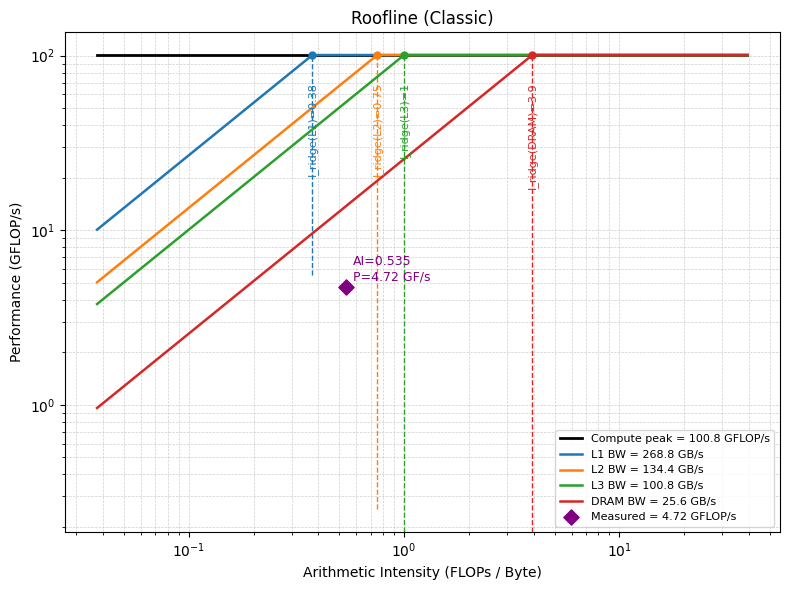

In [7]:
peak_gflops = 100.8
bandwidths = {'L1': 268.8, 'L2': 134.4, 'L3': 100.8, 'DRAM': 25.6}  # GB/s
total_flops = 137e9
runtime_s = 29
dram_bytes = 4e9 * 64  # classic roofline: FLOPs/DRAM_Bytes
fig, ax = plot_roofline(peak_gflops, bandwidths, total_flops, runtime_s, bytes_for_ai=dram_bytes, title="Roofline (Classic)")
plt.show()

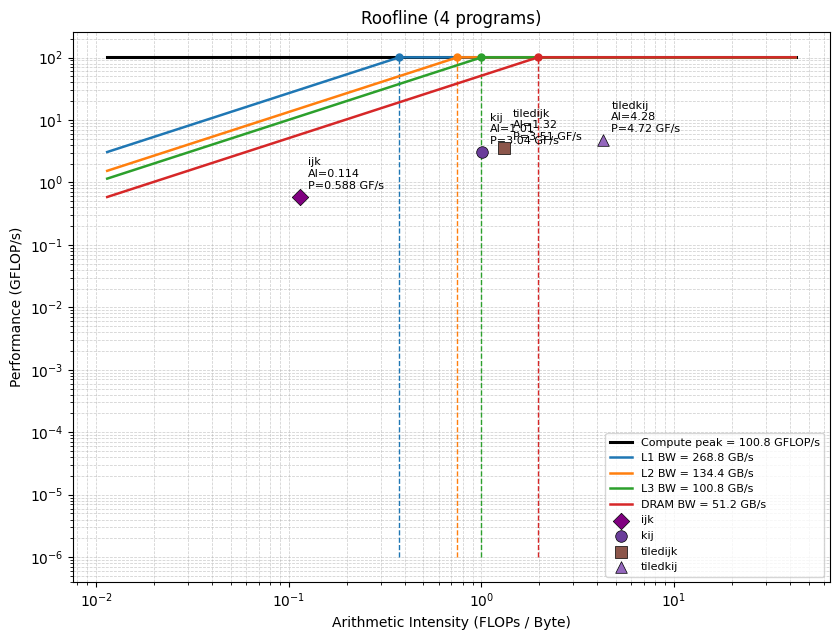

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Tuple

Program = Dict[str, object]
# Expected per program:
# {
#   "name": str,
#   "total_flops": float,   # total floating-point ops
#   "runtime_s": float,     # seconds
#   # EITHER of the following for AI bytes:
#   "bytes_for_ai": Optional[float],                # e.g., DRAM bytes (classic)
#   "bytes_by_level": Optional[Dict[str, float]],   # e.g., {"L1": ..., "L2": ..., "L3": ..., "DRAM": ...}
# }

def plot_roofline_multi(
    peak_gflops: float,
    bandwidths_gbs: Dict[str, float],
    programs: List[Program],
    *,
    title: str = "Roofline (4 programs)",
    annotate_points: bool = True,
    outfile: Optional[str] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot a cache-aware Roofline with common ceilings and multiple program dots.

    peak_gflops: compute roof in GFLOP/s (same precision for all points)
    bandwidths_gbs: dict like {'L1': GB/s, 'L2': GB/s, 'L3': GB/s, 'DRAM': GB/s}
    programs: list of dicts, each providing FLOPs, runtime, and bytes for AI (pref. L1 bytes)
    """
    # Prepare per-program AI and performance
    pts = []  # (name, AI, GFLOP/s)
    for prog in programs:
        name = str(prog["name"])
        flops = float(prog["total_flops"])
        t = float(prog["runtime_s"])
        gflops = (flops / t) / 1e9

        # Prefer cache-aware AI from L1 bytes if provided
        bytes_used = None
        if "bytes_by_level" in prog and prog["bytes_by_level"] is not None:
            bl = prog["bytes_by_level"]
            if "L1" in bl and bl["L1"] and bl["L1"] > 0:
                bytes_used = float(bl["L1"])
        if bytes_used is None:
            if "bytes_for_ai" in prog and prog["bytes_for_ai"] and prog["bytes_for_ai"] > 0:
                bytes_used = float(prog["bytes_for_ai"])
        if not bytes_used or bytes_used <= 0:
            raise ValueError(f"Program '{name}' missing valid bytes for AI (L1 preferred, else bytes_for_ai).")

        ai = flops / bytes_used
        pts.append((name, ai, gflops))

    # X-range using ridge points and program AIs
    ridges = {lvl: peak_gflops / bw for lvl, bw in bandwidths_gbs.items() if bw > 0}
    finite_ridges = [v for v in ridges.values() if np.isfinite(v) and v > 0]
    x_vals = [ai for _, ai, _ in pts] + finite_ridges
    x_min = max(min(x_vals) / 10.0, 1e-6) if x_vals else 1e-4
    x_max = max(max(x_vals) * 10.0, x_min * 1e3) if x_vals else 1e3
    x = np.logspace(np.log10(x_min), np.log10(x_max), 400)

    fig, ax = plt.subplots(figsize=(8.5, 6.5))

    # Draw compute roof
    y_compute = np.full_like(x, peak_gflops, dtype=float)
    ax.plot(x, y_compute, color='black', linewidth=2.2, label=f'Compute peak = {peak_gflops:.1f} GFLOP/s')

    # Memory roofs
    colors = {'L1': '#1f77b4', 'L2': '#ff7f0e', 'L3': '#2ca02c', 'DRAM': '#d62728'}
    for level, bw in sorted(bandwidths_gbs.items(), key=lambda kv: -kv[1]):
        y_bw = np.minimum(bw * x, peak_gflops)
        ax.plot(x, y_bw, color=colors.get(level, None), linewidth=1.8, label=f'{level} BW = {bw:.1f} GB/s')
        # Ridge marker
        if bw > 0:
            i_ridge = peak_gflops / bw
            if x_min < i_ridge < x_max:
                ax.plot(i_ridge, peak_gflops, 'o', color=colors.get(level, None), markersize=5)
                ax.vlines(i_ridge, ymin=max(1e-6, ax.get_ylim()[0]), ymax=peak_gflops,
                          colors=colors.get(level, None), linestyles='dashed', linewidth=1)

    # Plot up to four program points
    markers = ['D', 'o', 's', '^']
    cmap = ['purple', '#6a3d9a', '#8c564b', '#9467bd']
    for idx, (name, ai, gflops) in enumerate(pts[:4]):
        ax.scatter([ai], [gflops], s=70, marker=markers[idx % len(markers)],
                   color=cmap[idx % len(cmap)], edgecolors='k', linewidths=0.5, zorder=5, label=name)
        if annotate_points:
            ax.annotate(f'{name}\nAI={ai:.3g}\nP={gflops:.3g} GF/s',
                        xy=(ai, gflops), xytext=(6, 6), textcoords='offset points', fontsize=8)

    # Axes and legend
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Arithmetic Intensity (FLOPs / Byte)')
    ax.set_ylabel('Performance (GFLOP/s)')
    ax.set_title(title)
    ax.grid(True, which='both', linestyle='--', linewidth=0.55, alpha=0.6)
    ax.legend(loc='lower right', fontsize=8, frameon=True, ncol=1)
    fig.tight_layout()
    if outfile:
        fig.savefig(outfile, dpi=150)
    return fig, ax

# Example usage:
peak = 100.8
bws = {'L1': 268.8, 'L2': 134.4, 'L3': 100.8, 'DRAM': 51.2}  # GB/s
# programs = [
#   {"name":"ijk","total_flops":137e9,"runtime_s":233,"bytes_by_level":{"L1":2.2e12}},
#   {"name":"kij","total_flops":137e9,"runtime_s":45,"bytes_by_level":{"L1":0.8e12}},
#   {"name":"tiledijk","total_flops":137e9,"runtime_s":39,"bytes_by_level":{"L1":2.2e12}},
#   {"name":"tiledkij","total_flops":137e9,"runtime_s":29,"bytes_by_level":{"L1":2.3e12}},
# ]

programs = [
  {"name":"ijk","total_flops":137e9,"runtime_s":233,"bytes_by_level":{"L1":1.2e12}},
  {"name":"kij","total_flops":137e9,"runtime_s":45,"bytes_by_level":{"L1":0.136e12}},
  {"name":"tiledijk","total_flops":137e9,"runtime_s":39,"bytes_by_level":{"L1":0.104e12}},
  {"name":"tiledkij","total_flops":137e9,"runtime_s":29,"bytes_by_level":{"L1":0.032e12}},
]
fig, ax = plot_roofline_multi(peak, bws, programs, title="Roofline (4 programs)")
plt.show()


Wrote bfs_roofline.png


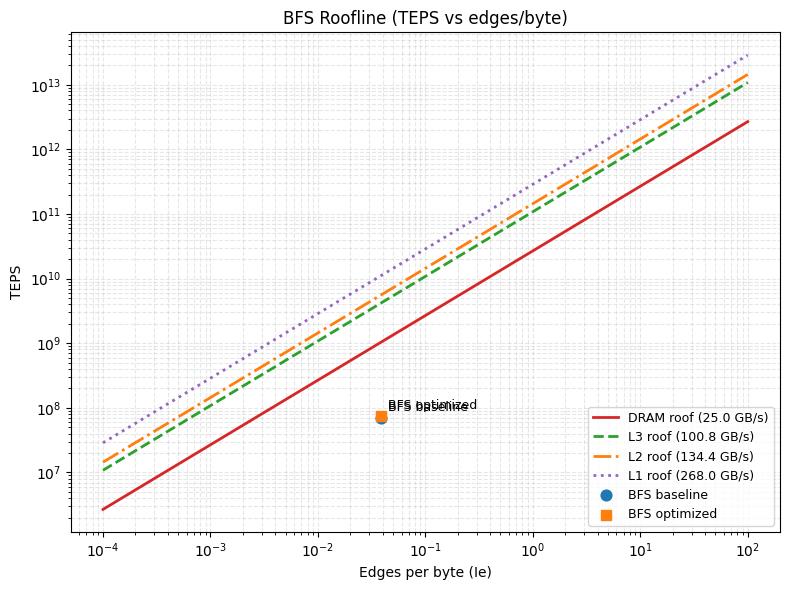

In [2]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
from math import inf

def bytes_per_second(gb_per_s, base=1_000_000_000.0):
    """
    Convert GB/s to bytes/s. Default uses decimal GB (1e9).
    If bandwidths were measured/reported in GiB/s, set base=1024**3.
    """
    return gb_per_s * base

def roofline_y(I, beta_Bps, pi_teps=inf):
    """
    Roofline equation in TEPS with intensity I in edges/byte and bandwidth beta in bytes/s:
    P(I) = min(pi, beta * I)
    """
    return np.minimum(pi_teps, beta_Bps * I)

def make_intensity_grid(I_min=1e-4, I_max=1e2, num=500):
    """
    Log-spaced intensity grid in edges/byte for smooth roof lines.
    """
    return np.logspace(np.log10(I_min), np.log10(I_max), num=num)

def plot_roofline(
    roofs_gbps,
    points,
    pi_teps=inf,
    title="BFS Roofline (TEPS vs edges/byte)",
    outfile="bfs_roofline.png",
    gb_base=1_000_000_000.0,
    annotate_points=True
):
    """
    Plot a roofline with multiple bandwidth ceilings.

    Parameters:
      roofs_gbps: list of (label, gb_per_s, color, linestyle) tuples, e.g.
                  [("DRAM", 40.0, "C3", "-"), ("L3", 300.0, "C2", "--"), ...]
      points: list of dicts with keys:
              {"label": str, "Ie": float, "teps": float, "marker": str, "color": str}
      pi_teps: compute roof in TEPS (float) or inf if effectively irrelevant
      title: plot title
      outfile: output image filename
      gb_base: 1e9 for GB/s or 1024**3 for GiB/s
    """
    # Build intensity grid spanning points and defaults
    Ie_vals = [max(1e-8, p["Ie"]) for p in points] if points else []
    I_min = min([1e-4] + Ie_vals)
    I_max = max([1e2] + Ie_vals)
    I = make_intensity_grid(I_min=I_min, I_max=I_max)

    plt.figure(figsize=(8, 6))

    # Memory roofs
    for label, gbps, color, ls in roofs_gbps:
        beta = bytes_per_second(gbps, base=gb_base)
        y = roofline_y(I, beta, pi_teps=pi_teps)
        plt.plot(I, y, ls, color=color, lw=2.0, label=f"{label} roof ({gbps:.1f} GB/s)")
        # Optional ridge marker if compute roof is finite
        if np.isfinite(pi_teps) and beta > 0:
            I_ridge = pi_teps / beta
            if I.min() <= I_ridge <= I.max():
                plt.plot([I_ridge], [pi_teps], marker="o", color=color, ms=5)

    # Compute roof (horizontal)
    if np.isfinite(pi_teps):
        plt.hlines(pi_teps, I.min(), I.max(), colors="k", linestyles=":", lw=2.0, label="Compute roof")

    # Plot measured points
    for p in points:
        plt.scatter(p["Ie"], p["teps"], marker=p.get("marker", "o"),
                    color=p.get("color", "C0"), s=60, zorder=5, label=p.get("label", None))
        if annotate_points and p.get("label"):
            plt.annotate(p["label"], xy=(p["Ie"], p["teps"]),
                         xytext=(5, 5), textcoords="offset points", fontsize=9)

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Edges per byte (Ie)")
    plt.ylabel("TEPS")
    plt.title(title)
    # Build legend without duplicating labels
    handles, labels = plt.gca().get_legend_handles_labels()
    seen = set()
    uniq = []
    for h, l in zip(handles, labels):
        if l and l not in seen:
            uniq.append((h, l))
            seen.add(l)
    if uniq:
        handles, labels = zip(*uniq)
        plt.legend(handles, labels, loc="lower right", fontsize=9, frameon=True)

    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=200)
    print(f"Wrote {outfile}")

if __name__ == "__main__":
    # ===== USER INPUT SECTION =====
    # Replace with system bandwidths (GB/s). If values are GiB/s, set gb_base=1024**3 below.
    dram_gbps = 25.0   # example
    l3_gbps   = 100.8  # example
    l2_gbps   = 134.4  # example
    l1_gbps   = 268 # example

    # Optional compute roof (TEPS). For BFS, computation is negligible; use a very large number.
    pi_teps = float("inf")  # or a finite value if a compute cap is desired

    # Measured points from your instrumented GAP BFS:
    # Fill in with printed "TEPS" and "Edges per byte (Ie)" for baseline and optimized versions.
    points = [
        {"label": "BFS baseline",   "Ie": 0.039, "teps": 69.76e6, "marker": "o", "color": "C0"},
        {"label": "BFS optimized",  "Ie": 0.039, "teps": 75.76e6, "marker": "s", "color": "C1"},
    ]

    roofs = [
        ("DRAM", dram_gbps, "C3", "-"),
        ("L3",   l3_gbps,   "C2", "--"),
        ("L2",   l2_gbps,   "C1", "-."),
        ("L1",   l1_gbps,   "C4", ":"),
    ]

    # If bandwidth inputs are GiB/s, set gb_base=1024**3
    plot_roofline(
        roofs_gbps=roofs,
        points=points,
        pi_teps=pi_teps,
        title="BFS Roofline (TEPS vs edges/byte)",
        outfile="bfs_roofline.png",
        gb_base=1024**3,  # change to 1024**3 if needed
        annotate_points=True
    )


Wrote bfs_roofline.png


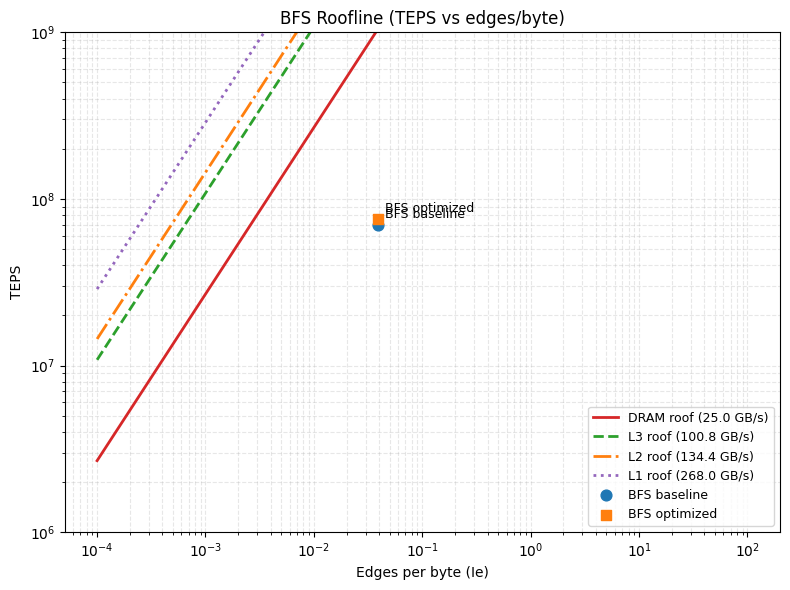

In [5]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
from math import inf

def bytes_per_second(gb_per_s, base=1_000_000_000.0):
    """
    Convert GB/s to bytes/s. Default uses decimal GB (1e9).
    If bandwidths were measured/reported in GiB/s, set base=1024**3.
    """
    return gb_per_s * base

def roofline_y(I, beta_Bps, pi_teps=inf):
    """
    Roofline equation in TEPS with intensity I in edges/byte and bandwidth beta in bytes/s:
    P(I) = min(pi, beta * I)
    """
    return np.minimum(pi_teps, beta_Bps * I)

def make_intensity_grid(I_min=1e-4, I_max=1e2, num=500):
    """
    Log-spaced intensity grid in edges/byte for smooth roof lines.
    """
    return np.logspace(np.log10(I_min), np.log10(I_max), num=num)

def plot_roofline(
    roofs_gbps,
    points,
    pi_teps=inf,
    title="BFS Roofline (TEPS vs edges/byte)",
    outfile="bfs_roofline.png",
    gb_base=1_000_000_000.0,
    annotate_points=True,
    y_min=None,
    y_max=None,
    y_pad_lo=0.5,
    y_pad_hi=2.0
):
    """
    Plot a roofline with multiple bandwidth ceilings.

    Parameters:
      roofs_gbps: list of (label, gb_per_s, color, linestyle) tuples.
      points: list of dicts: {"label": str, "Ie": float, "teps": float, "marker": str, "color": str}.
      pi_teps: compute roof in TEPS (float) or inf if effectively irrelevant.
      gb_base: 1e9 for GB/s or 1024**3 for GiB/s.
      y_min/y_max: optional manual y-axis bounds (in TEPS) on a log scale.
      y_pad_lo/y_pad_hi: multiplicative padding factors for auto-limits on log scale.
    """
    # Build intensity grid spanning data
    Ie_vals = [max(1e-8, p["Ie"]) for p in points] if points else []
    I_min = min([1e-4] + Ie_vals)
    I_max = max([1e2] + Ie_vals)
    I = make_intensity_grid(I_min=I_min, I_max=I_max)

    fig, ax = plt.subplots(figsize=(8, 6))

    # Memory roofs
    all_roof_y = []
    for label, gbps, color, ls in roofs_gbps:
        beta = bytes_per_second(gbps, base=gb_base)
        y = roofline_y(I, beta, pi_teps=pi_teps)
        ax.plot(I, y, ls, color=color, lw=2.0, label=f"{label} roof ({gbps:.1f} GB/s)")
        all_roof_y.append(y)
        # Optional ridge marker if compute roof is finite
        if np.isfinite(pi_teps) and beta > 0:
            I_ridge = pi_teps / beta
            if I.min() <= I_ridge <= I.max():
                ax.plot([I_ridge], [pi_teps], marker="o", color=color, ms=5)

    # Compute roof (horizontal)
    if np.isfinite(pi_teps):
        ax.hlines(pi_teps, I.min(), I.max(), colors="k", linestyles=":", lw=2.0, label="Compute roof")

    # Plot measured points
    for p in points:
        ax.scatter(p["Ie"], p["teps"], marker=p.get("marker", "o"),
                   color=p.get("color", "C0"), s=60, zorder=5, label=p.get("label", None))
        if annotate_points and p.get("label"):
            ax.annotate(p["label"], xy=(p["Ie"], p["teps"]),
                        xytext=(5, 5), textcoords="offset points", fontsize=9)

    # Log scales
    ax.set_xscale("log")
    ax.set_yscale("log")

    # Axis labels/title
    ax.set_xlabel("Edges per byte (Ie)")
    ax.set_ylabel("TEPS")
    ax.set_title(title)

    # Legend (deduplicate)
    handles, labels = ax.get_legend_handles_labels()
    seen, uniq = set(), []
    for h, l in zip(handles, labels):
        if l and l not in seen:
            uniq.append((h, l))
            seen.add(l)
    if uniq:
        handles, labels = zip(*uniq)
        ax.legend(handles, labels, loc="lower right", fontsize=9, frameon=True)

    # Auto y-limits if not provided: include roofs and points then pad
    if y_min is None or y_max is None:
        y_candidates = []
        for arr in all_roof_y:
            y_candidates.append(np.nanmin(arr[np.isfinite(arr)]))
            y_candidates.append(np.nanmax(arr[np.isfinite(arr)]))
        if points:
            y_candidates += [p["teps"] for p in points if p["teps"] > 0]
        # Filter positive values for log scale
        y_candidates = [y for y in y_candidates if y > 0 and np.isfinite(y)]
        if y_candidates:
            y_lo = min(y_candidates)
            y_hi = max(y_candidates)
            lo = y_lo * y_pad_lo
            hi = y_hi * y_pad_hi
        else:
            lo, hi = 1e3, 1e9  # fallback
        if y_min is None: y_min = lo
        if y_max is None: y_max = hi

    # Apply manual or computed limits (log-safe)
    if y_min is not None and y_max is not None:
        y_min = max(y_min, 1e-12)
        ax.set_ylim(y_min, y_max)

    ax.grid(True, which="both", ls="--", alpha=0.3)
    fig.tight_layout()
    fig.savefig(outfile, dpi=200)
    print(f"Wrote {outfile}")

if __name__ == "__main__":
    # ===== USER INPUT SECTION =====
    # Replace with system bandwidths (GB/s). If values are GiB/s, set gb_base=1024**3.
    dram_gbps = 51.2
    l3_gbps   = 100.8
    l2_gbps   = 134.4
    l1_gbps   = 268.8

    # Optional compute roof (TEPS). For BFS, computation is negligible; use a very large number.
    pi_teps = float("inf")

    # Measured points
    points = [
        {"label": "BFS baseline",   "Ie": 0.039, "teps": 69.76e6, "marker": "o", "color": "C0"},
        {"label": "BFS optimized",  "Ie": 0.039, "teps": 75.76e6, "marker": "s", "color": "C1"},
    ]

    roofs = [
        ("DRAM", dram_gbps, "C3", "-"),
        ("L3",   l3_gbps,   "C2", "--"),
        ("L2",   l2_gbps,   "C1", "-."),
        ("L1",   l1_gbps,   "C4", ":"),
    ]

    # Choose GiB/s conversion if inputs are GiB/s
    gb_base = 1024**3

    # Manually set y-limits to separate close points; adjust as desired
    y_min = 1e6
    y_max = 1e9

    plot_roofline(
        roofs_gbps=roofs,
        points=points,
        pi_teps=pi_teps,
        title="BFS Roofline (TEPS vs edges/byte)",
        outfile="bfs_roofline.png",
        gb_base=gb_base,
        annotate_points=True,
        y_min=y_min,
        y_max=y_max,
        y_pad_lo=0.5,   # used only if y_min/y_max are None
        y_pad_hi=2.0
    )
